# Estimating functional relationship

This notebook details the method train(), which estimates the functional relationships between variables.

## Import and settings

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from scipy.special import expit

from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import networkx as nx

from lingam.causal_based_simulator import CausalBasedSimulator
from lingam.utils import make_dot

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

## Creating test data
Create test data with variables from x0 to x5, of which x2 is a discrete variable.

### Causal graph

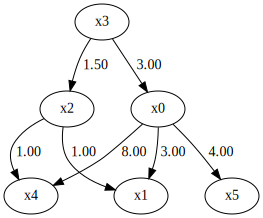

### Test data

,x0,x1,x2,x3,x4,x5
0,-0.725033,-0.853352,1,-0.298043,-5.518573,-3.361619
1,2.092471,5.580223,1,0.449011,17.970192,7.668833
2,3.251115,10.669606,1,0.965044,25.752890,11.510047
3,3.808976,13.150129,1,1.217832,30.951193,14.725043
4,3.023790,8.491654,1,1.096086,23.642615,11.167459


In [2]:
display(Markdown("### Causal graph"))

G = np.array([[0.0, 0.0, 0.0, 3.0, 0.0, 0.0],
              [3.0, 0.0, 1.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 1.5, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              [8.0, 0.0, 1.0, 0.0, 0.0, 0.0],
              [4.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

causal_order = [3, 2, 0, 4, 1, 5]

display(make_dot(G))

display(Markdown("### Test data"))

N = 1000
n_features = len(G)
discrete_index = 2

e = np.random.uniform(-np.sqrt(3), np.sqrt(3), size=(n_features, N))
X = np.empty((n_features, N))
for i in causal_order:
    X[i] = G[i] @ X + e[i]
    if i == discrete_index:
        X[i] = (expit(X[i]) >= np.random.uniform(size=N)).astype(int)
X = pd.DataFrame(X.T, columns=[f"x{i}" for i in range(n_features)])

X[f"x{discrete_index}"] = X[f"x{discrete_index}"].astype(int)

X.head()

## Estimate functional relationships between variables

By executing train() given test data and a causal graph, the functional relationships between each variable in the test data can be estimated. The model representing the functional relationships of each variable can be specified in the models argument. If not specified, a linear or logistic regression model is used by default.

The explanatory variables used for the model representing the functional relationships are determined by analyzing the causal graph in train(). To train each model, a column of explanatory and objective variables is taken from the given *X* and used. The most upstream variables do not have models.

In [3]:
sim = CausalBasedSimulator()
sim.train(X, G)

You can check *sim.train_result_* for the estimated model and a list of variables that are inputs to the estimated model. *train_reuslt_* is a dictionary whose keys are variable names. 

In [4]:
print(sim.train_result_.keys())

dict_keys(['x0', 'x1', 'x2', 'x3', 'x4', 'x5'])


### Contents of estimated results for x1

`sim.train_result_["x1"]` is a dictionary. This dictionary contains four items.

In [5]:
sim.train_result_["x1"].keys()

dict_keys(['model', 'parent_names', 'predicted', 'residual'])

In [6]:
display(Markdown("- model"))
print(sim.train_result_["x1"]["model"])

display(Markdown("- parent_names"))
print(sim.train_result_["x1"]["parent_names"])

display(Markdown("- predicted"))
print(sim.train_result_["x1"]["predicted"][:5])

display(Markdown("- residual\n"))
print(sim.train_result_["x1"]["residual"][:5])

- model

LinearRegression()


- parent_names

['x0', 'x2']


- predicted

[-1.181  7.272 10.749 12.423 10.067]


- residual


[ 0.328 -1.692 -0.079  0.728 -1.575]


## Estimate functional relationships between variables by specifying models

The functional relationships between variables is estimated by default using linear regression when the objective variable is a continuous variable and logistic regression when it is a discrete variable, but another machine learning model can be used by using the *models* option. Here we set up *x1* and *x2* to apply the random forest model as the models.

In [7]:
models = {
    "x1": RandomForestRegressor(),
    "x2": RandomForestClassifier(),
}

sim2 = CausalBasedSimulator()
sim2.train(X, G, models=models, is_discrete=X.dtypes==int)

print("x1", sim2.train_result_["x1"]["model"])
print("x2", sim2.train_result_["x2"]["model"])

x1 RandomForestRegressor()
x2 RandomForestClassifier()


We can confirm that the model for *x1" is a random forest regressor model and the model for *x2* is a random forest classifier model.

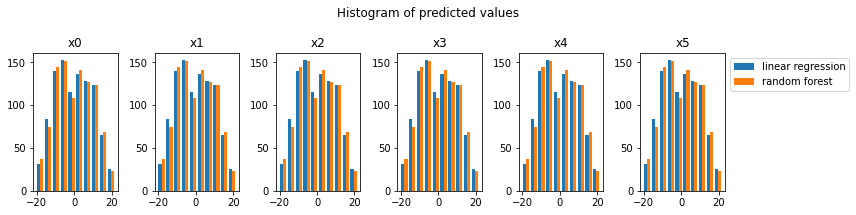

In [8]:
n_features = len(G)
fig, axes = plt.subplots(1, n_features, figsize=(n_features * 2, 3))

for ax, col in zip(axes, X.columns):
    pred_lr = sim.train_result_["x1"]["predicted"]
    pred_rf = sim2.train_result_["x1"]["predicted"]
    
    ax.hist((pred_lr, pred_rf), label=("linear regression", "random forest"))
    ax.set_title(col)
    if col == "x5":
        ax.legend(bbox_to_anchor=(1, 1))

plt.suptitle("Histogram of predicted values")
plt.tight_layout()
plt.show()

We can see that predicted values have changed from before the model change.